###Préparation des données

In [ ]:
!pip install hdbscan
!pip install nltk


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
import hdbscan
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
!git clone https://github.com/cvbrandoe/coursTAL.git
tm_data = "/content/coursTAL/2023/TMData/"

fatal: destination path 'coursTAL' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import re
trump = pd.read_csv('/content/coursTAL/2023/TMData/tweets_01-08-2021.csv')
trump.text = trump.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
trump.text = trump.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
trump.text = trump.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.text).split()), 1)
trump = trump.loc[(trump.isRetweet == "f") & (trump.text != ""), :]
tweets = trump.text.to_list()

In [ ]:
len(tweets)

45355

In [ ]:
# Prétraitement du texte
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

preprocessed_documents = [' '.join(preprocess_text(doc)) for doc in tweets[:500]] # if len(preprocess_text(doc)) > 6

In [ ]:
len(preprocessed_documents)

500

In [ ]:
preprocessed_documents

['republican democrat created economic problem',
 'thrilled back great city charlotte north carolina thousand hardworking american patriot love country cherish value respect law always put america first thank wonderful evening kag',
 'unsolicited mail ballot scam major threat democracy amp democrat know almost recent election using system even though much smaller amp far fewer ballot count ended disaster large number missing ballot amp fraud',
 'getting little exercise morning',
 'thank elise',
 'per request joe',
 'threshold identification ballot turning even bigger originally anticipated large number ballot impacted stay tuned',
 'running proud democrat senate sleepy joe biden today going get worse sustainable county china u',
 'huge win today united state peace world sudan agreed peace normalization agreement israel united arab emirate bahrain three arab country done matter week follow',
 'thank megyn',
 'day maga',
 'nevada turning cesspool fake vote amp finding thing released abso

###Création d'embeddings

In [ ]:
# Création des embeddings de texte avec Word2Vec
word2vec_model = Word2Vec([word_tokenize(doc.lower()) for doc in preprocessed_documents], min_count=1, vector_size=100)
word_vectors = word2vec_model.wv

# Calcul des embeddings moyens pour chaque document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

document_embeddings = [average_word_vectors(word_tokenize(doc.lower()), word2vec_model, word_vectors, 100) for doc in preprocessed_documents]

In [ ]:
len(document_embeddings[0])

100

###Reduction des dimensions 2D pour la visualisation

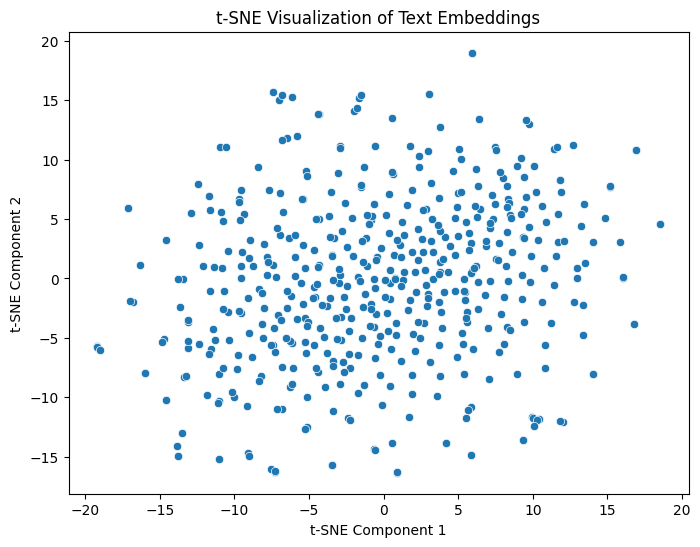

In [ ]:
import numpy as np

# Convertir la liste d'embeddings en un tableau NumPy
document_embeddings_np = np.array(document_embeddings)

# Réduction de dimension avec t-SNE pour visualisation des embeddings
tsne = TSNE(n_components=2, random_state=42)
document_embeddings_tsne = tsne.fit_transform(document_embeddings_np)

# Visualisation des embeddings avant clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=document_embeddings_tsne[:, 0], y=document_embeddings_tsne[:, 1])
plt.title("t-SNE Visualization of Text Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

### Algorithme K-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'K-means Clustering')

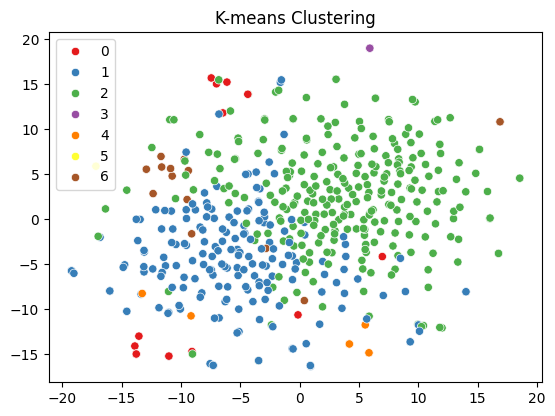

In [ ]:
# Clustering avec K-means des embeddings
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(document_embeddings)
kmeans_clusters = kmeans.labels_

# Visualisation des clusters
plt.figure(figsize=(14, 10))

# K-means, pour la visualisation on a réduit les embeddings avec TSNE
plt.subplot(2, 2, 1)
sns.scatterplot(x=document_embeddings_tsne[:, 0], y=document_embeddings_tsne[:, 1], hue=kmeans_clusters, palette="Set1", legend="full")
plt.title("K-means Clustering")


In [ ]:
import pandas as pd

# Associer chaque document à son cluster
clusters_df = pd.DataFrame({
    'Document': preprocessed_documents,
    'Cluster': kmeans_clusters
})

# Regrouper les données par cluster
cluster_groups = clusters_df.groupby('Cluster')

# Examinez les valeurs de chaque cluster
for cluster, group in cluster_groups:
    print(f"Cluster {cluster}:")
    print(group['Document'])
    print()


Cluster 0:
4               thank elise
9               thank megyn
26                    thank
55          thank wisconsin
107    thank elizabeth love
198             thank rabbi
257      thank pennsylvania
316              thank maga
326              thank nice
348                   thank
416             thank harry
468          thank michigan
485     thank macon georgia
496                   thank
Name: Document, dtype: object

Cluster 1:
2      unsolicited mail ballot scam major threat demo...
7      running proud democrat senate sleepy joe biden...
10                                              day maga
12     wisconsin looking good need little time statut...
16           georgia big presidential win night election
                             ...                        
482        trump georgia nobody done black community via
483    consent decree signed georgia secretary state ...
488    speaking important pennsylvania state senate h...
493    congress must covid relief bill nee

La fonction pairwise_distances_argmin_min est utilisée pour calculer les distances euclidiennes entre chaque point et son centroïde de cluster le plus proche. Enfin, nous calculons la distance intra-cluster moyenne pour chaque cluster en prenant la moyenne des distances de chaque point au centroïde de son cluster.

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min

# Obtenez les centroïdes des clusters
centroids = kmeans.cluster_centers_

# Obtenez les étiquettes de cluster attribuées par K-means
cluster_labels = kmeans.labels_

# Calculez les distances euclidiennes entre chaque point et son centroïde de cluster
distances = pairwise_distances_argmin_min(document_embeddings, centroids)

# Calculez la distance intra-cluster pour chaque cluster
intra_cluster_distances = {}
for cluster_idx in range(len(centroids)):
    cluster_points_idx = np.where(cluster_labels == cluster_idx)[0]
    cluster_distances = distances[1][cluster_points_idx]
    intra_cluster_distances[cluster_idx] = np.mean(cluster_distances)

# Affichez la distance intra-cluster pour chaque cluster
for cluster_idx, distance in intra_cluster_distances.items():
    print(f"Cluster {cluster_idx}: Distance intra-cluster = {distance}")


Cluster 0: Distance intra-cluster = 0.028130920277157606
Cluster 1: Distance intra-cluster = 0.021537746952089577
Cluster 2: Distance intra-cluster = 0.020964759134462524
Cluster 3: Distance intra-cluster = 0.0
Cluster 4: Distance intra-cluster = 0.028076027376501715
Cluster 5: Distance intra-cluster = 2.2812650937430355e-09
Cluster 6: Distance intra-cluster = 0.02928191061423026


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

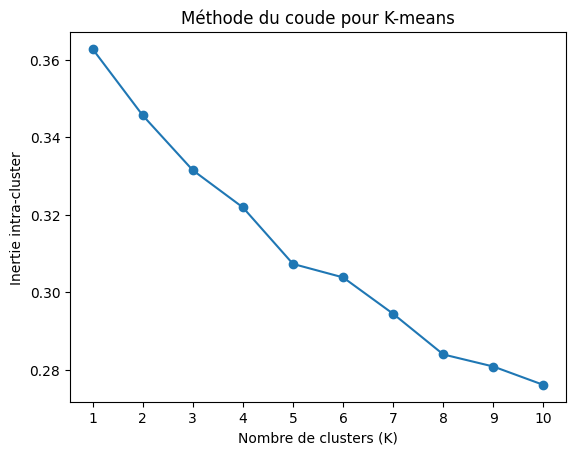

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Créer une liste pour stocker les valeurs d'inertie intra-cluster
inertia_values = []

# Nombre de clusters à tester
k_values = range(1, 11)  # Test de K de 1 à 10 clusters

# Calculer l'inertie intra-cluster pour différentes valeurs de K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(document_embeddings)
    inertia_values.append(kmeans.inertia_)

# Tracer la courbe de l'inertie intra-cluster en fonction de K
plt.plot(k_values, inertia_values, marker='o')
plt.title('Méthode du coude (Elbow) pour K-means')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Inertie intra-cluster')
plt.xticks(k_values)
plt.show()


###Affinity Propagation Clustering

Text(0.5, 1.0, 'Affinity Propagation Clustering')

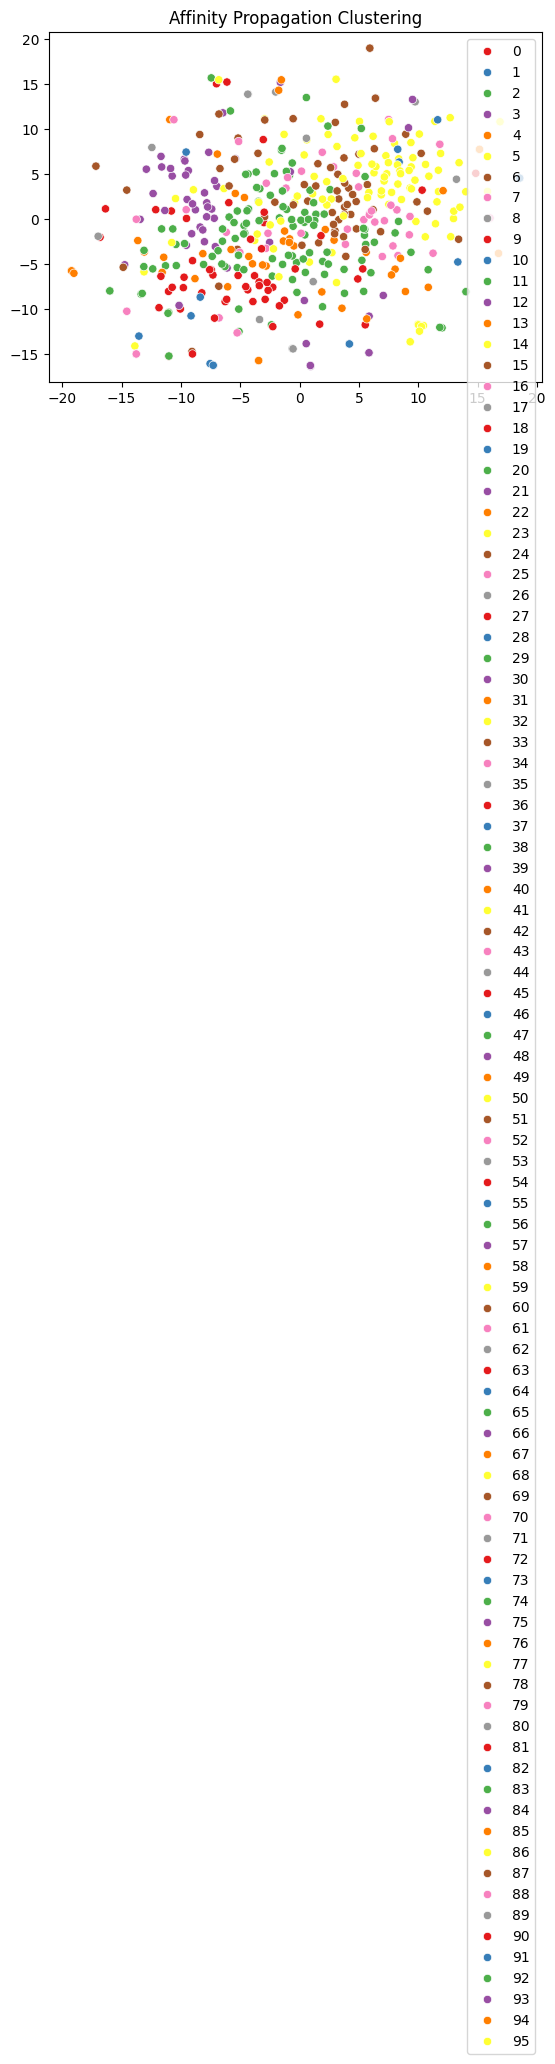

In [ ]:
# Clustering avec Affinity Propagation
aff_prop = AffinityPropagation(damping=0.5, random_state=42)
aff_prop_clusters = aff_prop.fit_predict(document_embeddings)

# Visualisation des clusters
plt.figure(figsize=(14, 10))

# Affinity Propagation
plt.subplot(2, 2, 3)
sns.scatterplot(x=document_embeddings_tsne[:, 0], y=document_embeddings_tsne[:, 1], hue=aff_prop_clusters, palette="Set1", legend="full")
plt.title("Affinity Propagation Clustering")


In [ ]:
import pandas as pd

# Associer chaque document à son cluster
clusters_df = pd.DataFrame({
    'Document': preprocessed_documents,
    'Cluster': aff_prop_clusters
})

# Regrouper les données par cluster
cluster_groups = clusters_df.groupby('Cluster')

# Examinez les valeurs de chaque cluster
for cluster, group in cluster_groups:
    print(f"Cluster {cluster}:")
    print(group['Document'])
    print()


Cluster 0:
4    thank elise
Name: Document, dtype: object

Cluster 1:
5    per request joe
Name: Document, dtype: object

Cluster 2:
9    thank megyn
Name: Document, dtype: object

Cluster 3:
10    day maga
Name: Document, dtype: object

Cluster 4:
15                     landed ohio see little
19    great ohio leaving wisconsin see little
Name: Document, dtype: object

Cluster 5:
25    biden lied pennsylvania
Name: Document, dtype: object

Cluster 6:
30    good news mean cc
Name: Document, dtype: object

Cluster 7:
17    thank ohio vote
35    thank ohio vote
Name: Document, dtype: object

Cluster 8:
49    see c
Name: Document, dtype: object

Cluster 9:
50    floyd county georgia
Name: Document, dtype: object

Cluster 10:
55    thank wisconsin
Name: Document, dtype: object

Cluster 11:
59    withdrew
Name: Document, dtype: object

Cluster 12:
60    georgia get today vote
Name: Document, dtype: object

Cluster 13:
61    nothing
Name: Document, dtype: object

Cluster 14:
65    wisconsin v

###Clustering avec Agglomerative Clustering

Text(0.5, 1.0, 'Agglomerative Clustering')

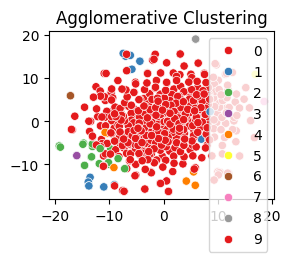

In [ ]:
# Clustering avec Agglomerative Clustering
agg_clusterer = AgglomerativeClustering(n_clusters=10)
agg_clusters = agg_clusterer.fit_predict(document_embeddings)

# Agglomerative Clustering
plt.subplot(2, 2, 4)
sns.scatterplot(x=document_embeddings_tsne[:, 0], y=document_embeddings_tsne[:, 1], hue=agg_clusters, palette="Set1", legend="full")
plt.title("Agglomerative Clustering")


In [ ]:
import pandas as pd

# Associer chaque document à son cluster
clusters_df = pd.DataFrame({
    'Document': preprocessed_documents,
    'Cluster': agg_clusters
})

# Regrouper les données par cluster
cluster_groups = clusters_df.groupby('Cluster')

# Examinez les valeurs de chaque cluster
for cluster, group in cluster_groups:
    print(f"Cluster {cluster}:")
    print(group['Document'])
    print()


Cluster 0:
0           republican democrat created economic problem
1      thrilled back great city charlotte north carol...
2      unsolicited mail ballot scam major threat demo...
3                        getting little exercise morning
5                                        per request joe
                             ...                        
493    congress must covid relief bill need democrat ...
494    steve scully bad week name announced said woul...
497    twitter shuts entire network slow spread negat...
498    lufkin texas someone stealing trump sign anony...
499    big voter fraud hearing today great state mich...
Name: Document, Length: 425, dtype: object

Cluster 1:
4                              thank elise
9                              thank megyn
26                                   thank
55                         thank wisconsin
107                   thank elizabeth love
196                       thank maine maga
198                            thank rabbi
257   

###HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)

Text(0.5, 1.0, 'HDBSCAN Clustering')

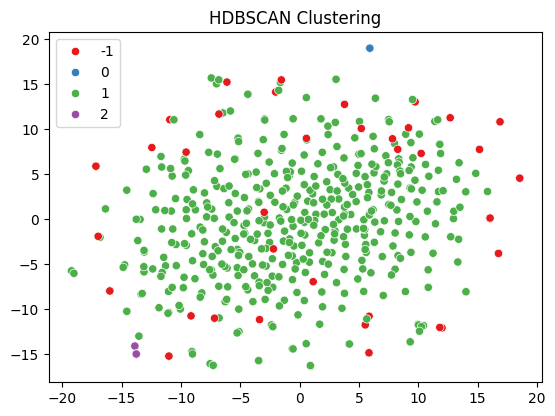

In [ ]:
# Clustering avec HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean')
hdbscan_clusters = hdbscan_clusterer.fit_predict(document_embeddings)

# Visualisation des clusters
plt.figure(figsize=(14, 10))

# HDBSCAN
plt.subplot(2, 2, 2)
sns.scatterplot(x=document_embeddings_tsne[:, 0], y=document_embeddings_tsne[:, 1], hue=hdbscan_clusters, palette="Set1", legend="full")
plt.title("HDBSCAN Clustering")

In [ ]:
import pandas as pd

# Associer chaque document à son cluster
clusters_df = pd.DataFrame({
    'Document': preprocessed_documents,
    'Cluster': hdbscan_clusters
})

# Regrouper les données par cluster
cluster_groups = clusters_df.groupby('Cluster')

# Examinez les valeurs de chaque cluster
for cluster, group in cluster_groups:
    print(f"Cluster {cluster}:")
    print(group['Document'])
    print()


Cluster -1:
49                  see c
59               withdrew
61                nothing
78                    win
79     happy thanksgiving
81                 thanks
94             much truth
139     voteearlyday maga
164                   say
173               amazing
180            much truth
198           thank rabbi
202                 agree
210           honor maine
215                   win
232             obamagate
277              virginia
279           great honor
300                appeal
319                appeal
340               neither
342                  vote
348                 thank
349             beautiful
355               correct
365               america
367                 agree
381           disgraceful
388     impossible result
391          michigan lot
399        thejusticedept
401         america first
404           coldcasejoe
406                   day
419          happy easter
424          watch ballot
427           great world
439                  vote


In [ ]:
import numpy as np

# Calculer le volume total de l'espace des données (nombre total de points)
total_points = len(document_embeddings)

# Calculer la densité moyenne de chaque cluster
cluster_densities = {}
unique_labels = np.unique(hdbscan_clusters)
for cluster_label in unique_labels:
    if cluster_label == -1:  # Les points non attribués sont étiquetés comme -1
        continue
    cluster_points = [document_embeddings[i] for i, label in enumerate(hdbscan_clusters) if label == cluster_label]
    cluster_density = len(cluster_points) / total_points
    cluster_densities[cluster_label] = cluster_density

# Afficher les densités moyennes de chaque cluster
for cluster_label, density in cluster_densities.items():
    print(f"Densité moyenne du cluster {cluster_label}: {density}")


Densité moyenne du cluster 0: 0.01
Densité moyenne du cluster 1: 0.892
Densité moyenne du cluster 2: 0.006


###Comparaison

In [ ]:
# Affichage des résultats
results = pd.DataFrame({
    'Document': preprocessed_documents,
    'K-means Cluster': kmeans_clusters,
    'HDBSCAN Cluster': hdbscan_clusters,
    'Affinity Propagation Cluster': aff_prop_clusters,
    'Agglomerative Clustering': agg_clusters
})

In [ ]:
results

,Document,K-means Cluster,HDBSCAN Cluster,Affinity Propagation Cluster,Agglomerative Clustering
0,republican democrat created economic problem,2,1,40,0
1,thrilled back great city charlotte north carol...,2,1,56,0
2,unsolicited mail ballot scam major threat demo...,2,1,56,0
3,getting little exercise morning,2,1,51,0
4,thank elise,1,1,0,1
...,...,...,...,...,...
495,great,1,-1,93,4
496,thank,1,2,61,1
497,twitter shuts entire network slow spread negat...,2,1,52,0
498,lufkin texas someone stealing trump sign anony...,2,1,68,0


Variez la taille du jeu des données de départ ou choisissez un sous-ensemble des données de manière ciblée, les paramètres des différentes méthodes de clustering, notamment le nombre de cluster pour k-means...